# xwOBA K-Nearest Neighbors 
In this project, the 2022 baseball season (April 7, 2022 - October 2, 2022) will be leveraged to predict wOBA values for balls in play. wOBA is an on-base percentage that accounts for how a player reached base with each event corresponding to a different wOBA value. Home runs have the highest wOBA value and an out has the lowest wOBA value. In order to predict wOBA values, launch angle and launch velocity will be the two variables examined. 

To predict wOBA values, a k-nearest neighbor model will be conducted. K-nearest neighbor classifies the data point based on the k nearest data points. For example, if the k value was 10, the 10 points that are closest in distance would be used to classify the data point. The ideal k value will be determined further down in the project through cross validation. 


## Data Collection
To begin, the 2022 baseball season will be imported below through statcast. Once, the data is loaded, we print the column names out in order to determine our primary key. We will use a primary key later in the project which will allow us to join the main data table to our model. The columns that will be used to create the primary key are game_pk, at_bat_number, and pitch_number because they create a unique event when combined. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pybaseball import statcast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import log_loss
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss


In [2]:
stat_df = statcast(start_dt="2022-04-07", end_dt="2022-10-02")

This is a large query, it may take a moment to complete


  0%|                                                                                          | 0/179 [00:00<?, ?it/s]C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%|▍                                                                                 | 1/179 [00:18<54:04, 18.23s/it]C:\Users\AGaev\AppData\Local\Programs\Python\Python311\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
  1%

In [3]:
#Full data set
stat_df

#To see the columns in data set in order to determine the primary key. 
for col in stat_df.columns:
    print(col)

pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
fielder_2
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
pitcher.1
fielder_2.1
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignment
spin_axi

In [4]:
#To create a unique key
stat_df["primary_key"] = [str(x) + "_" + str(y) + "_" + str(z) for x, y, z in zip(stat_df["game_pk"], stat_df["at_bat_number"], stat_df["pitch_number"])]
stat_df[["primary_key","game_pk", "at_bat_number", "pitch_number"]]


,primary_key,game_pk,at_bat_number,pitch_number
2748,663419_78_6,663419,78,6
2862,663419_78_5,663419,78,5
2891,663419_78_4,663419,78,4
3028,663419_78_3,663419,78,3
3181,663419_78_2,663419,78,2
...,...,...,...,...
1729,661042_1_5,661042,1,5
1793,661042_1_4,661042,1,4
1837,661042_1_3,661042,1,3
1961,661042_1_2,661042,1,2


Create a data table 

In [5]:
#Exit Velocity and Launch Angle
bip_df = stat_df[(pd.notnull(stat_df["bb_type"]))]
bip_df = bip_df.dropna(how="any", subset=["launch_speed", "launch_angle"])
list(set(bip_df["description"]))

['hit_into_play']

In [6]:
bip_df["ev_round"] = [round(ev) for ev in bip_df["launch_speed"]]
bip_df["la_round"] = [round(la) for la in bip_df["launch_angle"]]

### Visualize the Data
Now that the data is ready, we are going to create a visual through a scatter plot. In the below scatter plot, there is exit velocity and launch angle with wOBA values displayed in a coolwarm color scale. Red indicates a high wOBA value and blue is a low wOBA value. In the graph, the high wOBA values which are likely homeruns occur when the exit velocity is between ~100-120mph and a launch angle of ~20-50 degrees. 

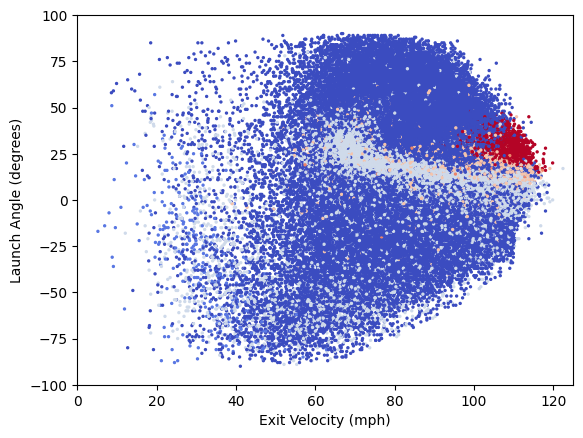

In [7]:
#Plot of the Data with wOBA values on a coolwarm color scale
fig, ax = plt.subplots()
plt.scatter(x=bip_df["launch_speed"], y=bip_df["launch_angle"], c=bip_df["woba_value"], s=2, cmap="coolwarm")
ax.set_xlim(0,125)
ax.set_ylim(-100,100)
ax.set_xlabel("Exit Velocity (mph)")
ax.set_ylabel("Launch Angle (degrees)")
plt.show()

When creating a model for this data, we only want to use the necessary columns. Thus, a new data table called ev_la_df is created with launch_speed, launch_angle, events, and primary_key as the columns. 

In [8]:
bip_df.isnull().values.any()

# Identify rows with NaN values
rows_with_nan = bip_df[bip_df.isnull().any(axis=1)]
 
#View the rows with NaN values
print(rows_with_nan)

#New Data table that includes Launch Speed, Launch Angle, and Events
#Make sure to add the columns needed for the primary key to the below code
ev_la_df = bip_df[["launch_speed", "launch_angle", "events","primary_key"]]

ev_la_df

     pitch_type  game_date  release_speed  release_pos_x  release_pos_z  \
3482         CU 2022-10-02           78.4           1.95           5.71   
4090         CH 2022-10-02           78.8           1.86            5.8   
2451         FF 2022-10-02           96.9          -2.12           5.78   
3672         FF 2022-10-02           98.5          -2.23           5.78   
1373         SI 2022-10-02           92.9           1.98           5.41   
...         ...        ...            ...            ...            ...   
1518         SI 2022-04-07           92.9           0.96           5.98   
1992         SI 2022-04-07           94.2           0.84           6.14   
1008         FF 2022-04-07           98.0           -2.0           5.95   
1375         FF 2022-04-07           97.7          -1.83           5.94   
1685         FF 2022-04-07           99.0          -2.01            5.9   

          player_name  batter  pitcher                     events  \
3482   Zastryzny, Rob  608369 

,launch_speed,launch_angle,events,primary_key
3482,54.2,37,field_out,663419_77_5
4090,95.1,25,field_out,663419_76_3
2451,100.5,0,grounded_into_double_play,663419_75_5
3672,88.6,39,field_out,663419_73_6
1373,97.1,4,single,663419_67_4
...,...,...,...,...
1518,80.2,-26,grounded_into_double_play,661042_8_4
1992,88.7,-53,field_out,661042_6_1
1008,81.5,64,field_out,661042_5_2
1375,80.7,-34,force_out,661042_3_5


## Model Build

Now that we have a data set with only the necessary columns, it is time to build the model. In this section, each event is indexed from 0 to 5. 

Events
- Out = 0
- Single = 1
- Double = 2
- Triple = 3
- Home Run = 4
- Anything Else = 5

Then the data is split into a training and test set with 75% of the data in the training set and 25% in the test set. Splitting the data into a training and test set is important because it will allow us to assess how well the model performs on unseen data in the test set. 

In [9]:
#Categorize the events: Out, Single, Double, Triple, and Homerun
ev_la_df = ev_la_df[ev_la_df["events"].isin(["field_out", "single", "double", "triple", "home_run"])]
ev_la_df["events_encoded"] = [0 if x == "field_out" 
                                  else 1 if x == "single" 
                                  else 2 if x == "double" 
                                  else 3 if x == "triple" 
                                  else 4 if x == "home_run" 
                                  else 5 for x in ev_la_df["events"]]


# Split the data into features (X) and target (y)
X = ev_la_df.drop("events_encoded", axis=1)
Y = ev_la_df["events_encoded"]

# Split the data into training and test sets: 75% of the data is for training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.75)

C:\Users\AGaev\AppData\Local\Temp\ipykernel_13420\4259201165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ev_la_df["events_encoded"] = [0 if x == "field_out"


Since the data is split the next step is to scale it. The data needs to be scaled because the model is distance based and we do not want the magnitude of one variable to affect the model. The result is launch speed and launch angle will be on the same scale. 

In [18]:
#Scale the data
scaler= StandardScaler()
features = ["launch_speed", "launch_angle"]
X_train_scale = scaler.fit_transform(X_train[features])
X_test_scale = scaler.transform(X_test[features])

Next, the ideal k value is determined by looking at values from 1 to 300 with GridSearchCV, which is a form of cross validation, performed on the training set. 

In [19]:
#Determining the best K value
knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(30,300,30)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X_train_scale, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 30,  60,  90, 120, 150, 180, 210, 240, 270])})

The best k value for this data set is 90 and at that value, the accuracy of the model is 75.67%

In [20]:
#check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 90}

In [21]:
#The ideal k value is 90
#Find the accuracy score of the model
knn_gscv.score(X_test_scale, Y_test)

0.7567346250647271

Next, preds_test is created to show the probablities of each event for every data point within X_test. For example, the first data point has a probability of 14.44% for an out, 0% for a single, 1.11% for a double, 0% for a triple and 84.44% for a homerun. 

In [22]:
#preds_test is an array with the probabilities of each event for every data point within X_test
preds_test = knn_gscv.predict_proba(X_test_scale)
preds_test

array([[0.14444444, 0.        , 0.01111111, 0.        , 0.84444444],
       [0.34444444, 0.56666667, 0.08888889, 0.        , 0.        ],
       [0.93333333, 0.04444444, 0.02222222, 0.        , 0.        ],
       ...,
       [0.37777778, 0.56666667, 0.05555556, 0.        , 0.        ],
       [0.32222222, 0.58888889, 0.06666667, 0.02222222, 0.        ],
       [0.98888889, 0.        , 0.01111111, 0.        , 0.        ]])

Below, the wOBA_weights array is created which are sourced from the MLB. In order to get the wOBA values, preds_test (probability matrix) is multiplied by wOBA_weights and then each row in wOBA_values is summed together to get the final wOBA value for each data point. For example, the first data point has a wOBA value of 1.7027 which indicates that the outcome was either a triple or a home run. The reason it is a triple or a home run is because 1.7027 falls between the triple value of 1.6 and the home run value of 2. 

In [23]:
#wOBA weights from MLB
wOBA_weights = np.array([0,0.9,1.25,1.6,2])

#wOBA values are calculated by multiplying preds_test (probablilty matrix) with wOBA_weights
wOBA_values = preds_test*wOBA_weights
wOBA_values



array([[0.        , 0.        , 0.01388889, 0.        , 1.68888889],
       [0.        , 0.51      , 0.11111111, 0.        , 0.        ],
       [0.        , 0.04      , 0.02777778, 0.        , 0.        ],
       ...,
       [0.        , 0.51      , 0.06944444, 0.        , 0.        ],
       [0.        , 0.53      , 0.08333333, 0.03555556, 0.        ],
       [0.        , 0.        , 0.01388889, 0.        , 0.        ]])

In [24]:
#Sum the values in each row. Summing across all possible events for each row
wOBA_values.sum(axis = 1)

array([1.70277778, 0.62111111, 0.06777778, ..., 0.57944444, 0.64888889,
       0.01388889])

Next, to determine the exit velocity and launch speed for each wOBA value, scaler.inverse_tranform (X_test) is performed. This reverses the data from the scaled form to the original form. For the first data point, the exit velocity was 109.6 mph and the launch angle was 37 degrees. 

In [25]:
#This gives the exit velocity and launch speed for each wOBA value
X_test_raw = scaler.inverse_transform(X_test_scale)
X_test_raw

array([[109.6,  37. ],
       [104.2,   4. ],
       [ 77.4,  46. ],
       ...,
       [103.6,   1. ],
       [108. ,   6. ],
       [ 84.1,  33. ]])

Now we are going to create a scatter plot using the model on the test data. When looking at the below scatter plot, you will notice that the plot looks very similar to the scatter plot we created at the beginning of the project. This is a good sign because it indicates that our model is performing similar to the actual data. 

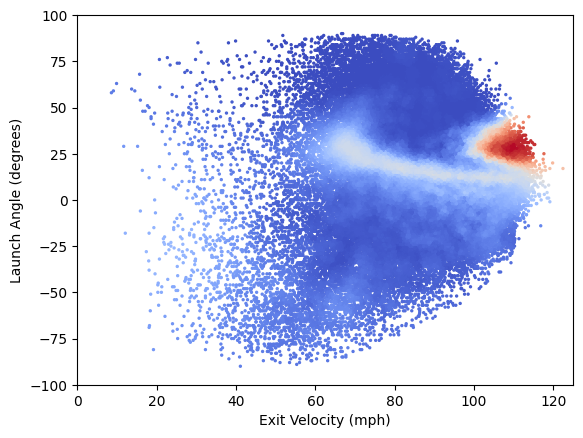

In [27]:
#Plot using the model
#Red are high wOBA values
#White are wOBA values in the middle
#Blue are low wOBA values
fig, ax = plt.subplots()
plt.scatter(x= X_test_raw[:,0], y= X_test_raw[:,1], c=wOBA_values.sum(axis =1), s=2, cmap="coolwarm")
ax.set_xlim(0,125)
ax.set_ylim(-100,100)
ax.set_xlabel("Exit Velocity (mph)")
ax.set_ylabel("Launch Angle (degrees)")
plt.show()

## Assessing the Model

Since the model has been created, the next step is to assess it. To assess the model, log loss is performed which shows how close the predicted value is to the corresponding actual value. The log loss value for this model is 0.701087 which is high. This indicates that there is variance between the predictions and the actual values. This also means that the model is not very accurate at predictng wOBA values.

In [28]:
#Log Loss. Compare to a baseline model with a default k nearest neighbors. The lower log loss number is better because it means there is less variance.
log_loss(Y_test, preds_test)

0.7010870208179865

### Calibration curves for each event

In [29]:
#Calibration Curve for Each Event
def plot_calibration_curve(y_test, target_class, preds):
    """ This function ingests a target variable
    and predicted probabilities to generate
    a calibration cure

    @param y_test: This list contains the multiclass target
      for our hit type model
    @param target_class: Integer corresponding to one target
       in the y_test list
    @param preds: Numpy array of predicted probabilities for
       each target class in y_test
    
    Returns:
    
       -fig: Matplotlib object calibration curve
    """
    #Convert multiclass target to binary based on target class
    binary_target = [1 if y==target_class else 0 for y in y_test]
    
    # Initialize visualizaton
    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)

    fraction_of_positives, mean_predicted_value = \
    calibration_curve(binary_target, preds [:,target_class], n_bins=10)
    ax1.plot(mean_predicted_value, fraction_of_positives, "s-")
    ax1.set_xlabel("Predicted Frequency")
    ax1.set_ylabel("Observed Frequency")
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.close ()
    
    return fig

In [30]:
fig_list = []
for target in range(0,5):
    fig = plot_calibration_curve(y_test = Y_test,target_class = target,preds = preds_test)
    fig_list.append(fig)

### Calibration Curve for an Out

In the calibration curve for an out, one can see that the blue line looks very similar to the dotted line, almost inline with it. This means that the model is very good at predicting outs, especially when the predicted frequency is above 0.4. 

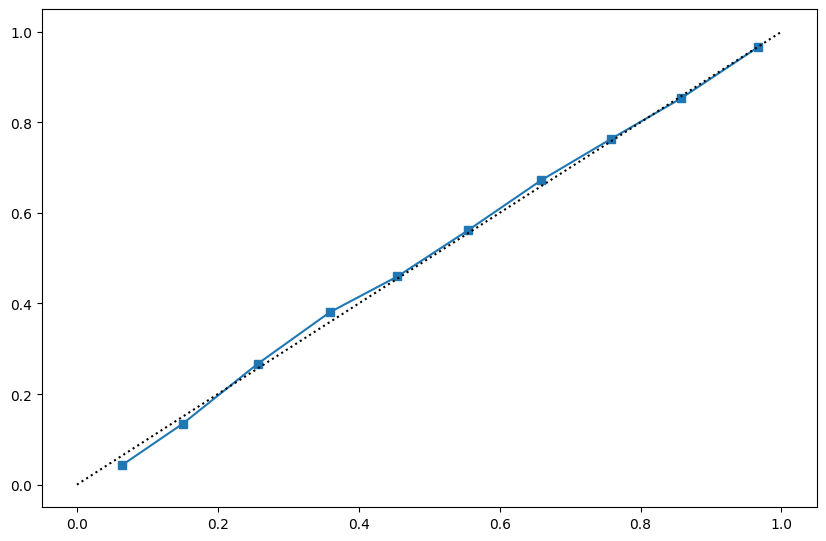

In [31]:
#Plot of calibration curve for an out
#Y axis is the fraction of outs over all plays in that bin
#X axis the mean propability for each bin
#perfectly calibrated would be if the blue line was inline with the y=x line
fig_list[0]


### Calibration Curve for a Single

Below is a calibration curve for a single which shows that the blue line is almost inline with the dotted line (almost fully calibrated). It would be fully calibrated except the predicted frequency between 0.65 and 0.85, the blue line is not inline with the dotted line. Even though there is an area where the line is not fully calibrated, it is very close. Thus, this curve shows that the model is good at predicting singles. Slightly underpredicting singles in this range.

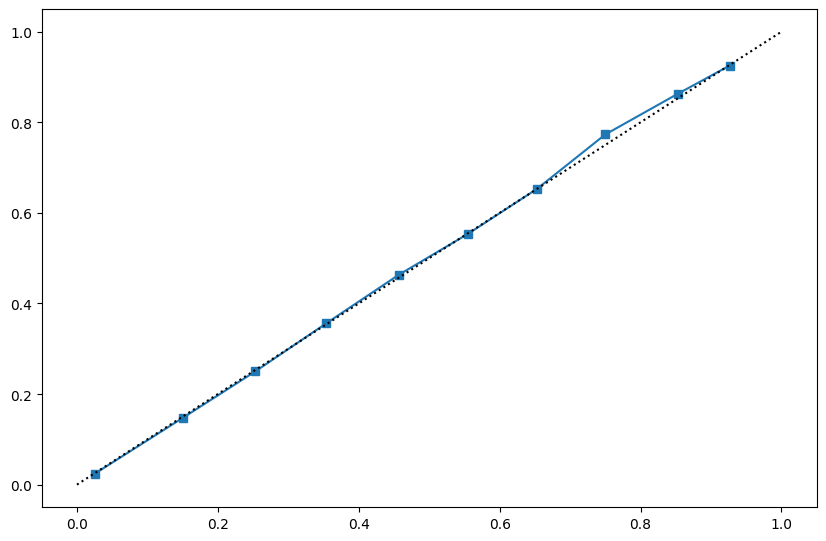

In [32]:
#Plot of calibration curve for a single. predicted probability and observed probablilty.
fig_list[1]

### Calibration Curve for a Double

For the double calibration curve, one can see that the blue line is close to the dotted line except it drops off around 0.6 for the predicted frequency. 

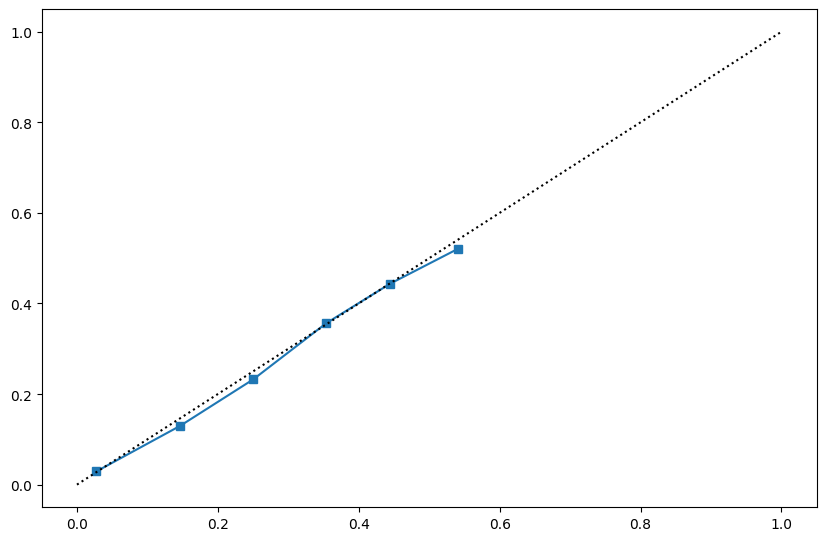

In [33]:
#Plot of calibration curve for a double. Model making out around 60% do to other hit types. Doubles often are hit off the wall which are close to home runs which in one park can be a home run and another a double. 
fig_list[2]

### Calibration Curve for a Triple

The triple's calibration curve is a single point which is due to the fact that hitting a triple in baseball is rare. Thus, there is not a lot of data for the model to learn off of, making it difficult to predict triples. Additionally, a batter's speed around the bases is also a factor in whether the outcome is a triple. For example, a fast batter can extend a double into a triple.

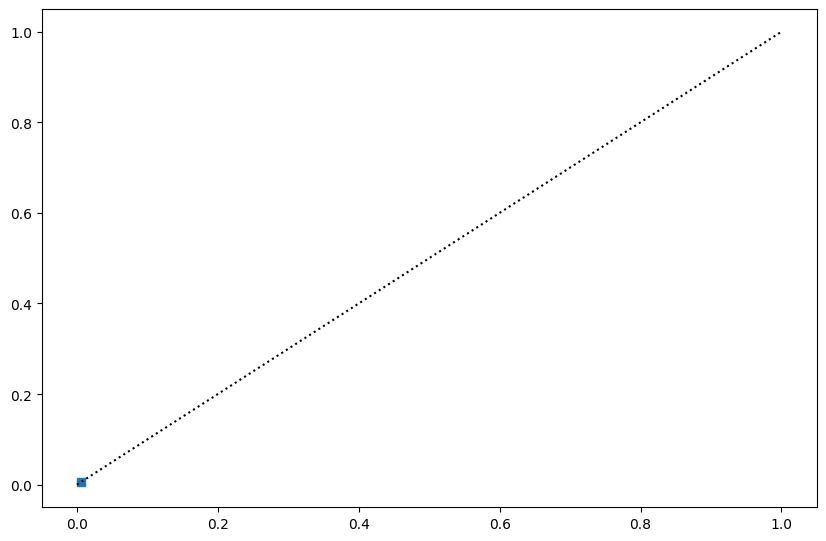

In [34]:
#Plot of calibration curve for a triple
fig_list[3]

### Calibration Curve for a Home Run

Similar to the other calibration curves, the blue line is close to the dotted line but not as inline. This means that the model is pretty good at predicting home runs but is not perfect. Underpredicting homeruns at the upper end could be due to park dimensions. This is also true for over predicting at the lower end. 

In [2]:
#Plot of calibration curve for a home run
fig_list[4]

NameError: name 'fig_list' is not defined

### Data Exploration

In [36]:
#Data Exploration
#Shows the probablility of each event for the given exit velocity and launch angle. A 1 indicates if the event occurred. 
test_df = X_test
for target in range(0,5):
    test_df["target_" + str(target)] = [1 if y==target else 0 for y in Y_test]
    test_df["pred_" + str(target)] = preds_test[:, target]
test_df

,launch_speed,launch_angle,events,primary_key,target_0,pred_0,target_1,pred_1,target_2,pred_2,target_3,pred_3,target_4,pred_4
17,109.6,37,home_run,662326_46_5,0,0.144444,0,0.000000,0,0.011111,0,0.000000,1,0.844444
1335,104.2,4,field_out,661119_20_5,1,0.344444,0,0.566667,0,0.088889,0,0.000000,0,0.000000
1008,77.4,46,field_out,662793_34_1,1,0.933333,0,0.044444,0,0.022222,0,0.000000,0,0.000000
764,90.0,41,field_out,663115_24_7,1,0.988889,0,0.000000,0,0.011111,0,0.000000,0,0.000000
227,91.9,2,field_out,661570_39_4,1,0.488889,0,0.433333,0,0.077778,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2483,76.8,-30,double,662127_7_2,0,0.922222,0,0.077778,1,0.000000,0,0.000000,0,0.000000
2893,59.3,15,field_out,661777_86_5,1,0.755556,0,0.200000,0,0.044444,0,0.000000,0,0.000000
919,103.6,1,field_out,662390_30_6,1,0.377778,0,0.566667,0,0.055556,0,0.000000,0,0.000000
3044,108.0,6,single,661843_15_5,0,0.322222,1,0.588889,0,0.066667,0,0.022222,0,0.000000


In [37]:
Combined_df = stat_df.merge(test_df.drop(columns = ["launch_speed", "launch_angle","events"]), on = "primary_key")
Combined_df

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,target_0,pred_0,target_1,pred_1,target_2,pred_2,target_3,pred_3,target_4,pred_4
0,CH,2022-10-02,78.8,1.86,5.8,"Zastryzny, Rob",543760,642239,field_out,hit_into_play,...,1,0.811111,0,0.011111,0,0.155556,0,0.011111,0,0.011111
1,SI,2022-10-02,92.9,1.98,5.41,"King, John",664058,667463,single,hit_into_play,...,0,0.333333,1,0.588889,0,0.066667,0,0.011111,0,0.000000
2,SI,2022-10-02,92.4,2.05,5.42,"King, John",666176,667463,single,hit_into_play,...,0,0.322222,1,0.588889,0,0.088889,0,0.000000,0,0.000000
3,CH,2022-10-02,83.2,2.2,5.24,"King, John",681351,667463,single,hit_into_play,...,0,0.555556,1,0.388889,0,0.055556,0,0.000000,0,0.000000
4,SI,2022-10-02,91.4,4.27,4.48,"Loup, Aaron",663993,571901,field_out,hit_into_play,...,1,0.811111,0,0.144444,0,0.044444,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83036,FF,2022-04-07,93.9,0.92,6.08,"Valdez, Framber",622110,664285,single,hit_into_play,...,0,0.855556,1,0.133333,0,0.000000,0,0.011111,0,0.000000
83037,FF,2022-04-07,98.9,-2.22,5.81,"Ohtani, Shohei",663656,660271,field_out,hit_into_play,...,1,0.577778,0,0.344444,0,0.077778,0,0.000000,0,0.000000
83038,SI,2022-04-07,94.2,0.84,6.14,"Valdez, Framber",660271,664285,field_out,hit_into_play,...,1,0.822222,0,0.177778,0,0.000000,0,0.000000,0,0.000000
83039,FF,2022-04-07,98.0,-2.0,5.95,"Ohtani, Shohei",493329,660271,field_out,hit_into_play,...,1,0.988889,0,0.011111,0,0.000000,0,0.000000,0,0.000000


In [38]:
#Shows the difference between the target value and the predicited value for each event in the data set

Combined_df["diff_0"] = Combined_df["target_0"] - Combined_df["pred_0"]
Combined_df.sort_values("diff_0")

Combined_df["diff_1"] = Combined_df["target_1"] - Combined_df["pred_1"]
Combined_df.sort_values("diff_1")

Combined_df["diff_2"] = Combined_df["target_2"] - Combined_df["pred_2"]
Combined_df.sort_values("diff_2")

Combined_df["diff_3"] = Combined_df["target_3"] - Combined_df["pred_3"]
Combined_df.sort_values("diff_3")

Combined_df["diff_4"] = Combined_df["target_4"] - Combined_df["pred_4"]
Combined_df.sort_values("diff_4")

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,pred_2,target_3,pred_3,target_4,pred_4,diff_0,diff_1,diff_2,diff_3,diff_4
23667,FF,2022-08-13,89.4,2.75,5.28,"Logue, Zach",676801,656657,triple,hit_into_play,...,0.011111,1,0.000000,0,0.977778,-0.011111,0.000000,-0.011111,1.000000,-0.977778
67934,FA,2022-05-10,54.6,-1.39,6.63,"Phillips, Brett",660271,621433,double,hit_into_play,...,0.011111,0,0.000000,0,0.966667,-0.011111,-0.011111,0.988889,0.000000,-0.966667
32616,FF,2022-07-25,92.6,-2.5,6.24,"Hutchison, Drew",572228,571800,double,hit_into_play,...,0.011111,0,0.000000,0,0.966667,-0.011111,-0.011111,0.988889,0.000000,-0.966667
22600,SI,2022-08-15,91.2,-2.57,6.27,"Hutchison, Drew",660757,571800,double,hit_into_play,...,0.000000,0,0.000000,0,0.966667,-0.033333,0.000000,1.000000,0.000000,-0.966667
43741,FC,2022-06-29,89.7,-1.41,6.27,"Quantrill, Cal",596142,615698,double,hit_into_play,...,0.000000,0,0.000000,0,0.966667,-0.033333,0.000000,1.000000,0.000000,-0.966667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56172,FF,2022-06-03,91.3,0.93,5.99,"Minor, Mike",657041,501985,home_run,hit_into_play,...,0.022222,0,0.000000,1,0.000000,-0.966667,-0.011111,-0.022222,0.000000,1.000000
1932,FC,2022-09-28,88.0,-2.5,5.79,"Kremer, Dean",657077,665152,home_run,hit_into_play,...,0.255556,0,0.000000,1,0.000000,-0.677778,-0.066667,-0.255556,0.000000,1.000000
55933,FF,2022-06-04,93.9,-2.36,6.47,"Hamilton, Ian",665489,641656,home_run,hit_into_play,...,0.155556,0,0.011111,1,0.000000,-0.800000,-0.033333,-0.155556,-0.011111,1.000000
24243,SL,2022-08-12,81.9,-1.56,5.12,"Scott, Tayler",596748,605463,home_run,hit_into_play,...,0.366667,0,0.011111,1,0.000000,-0.488889,-0.133333,-0.366667,-0.011111,1.000000
